# Loan Acceptance Classifier

### Imports and Settings

##### Imports

In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
from ray import tune, train
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering

##### Settings

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

##### Loading the training and validation data:

In [3]:
data_train=pl.read_parquet('data/data_full_train.parquet')
data_val=pl.read_parquet('data/data_full_val.parquet')

##### Running cleaning and feature engineering functions:

In [4]:
data_train=dmf.clean_accepted_rejected(data_train)
data_val=dmf.clean_accepted_rejected(data_val)

data_train=feats.date_features_accepted_rejected(data_train,"Application Date")
data_val=feats.date_features_accepted_rejected(data_val,"Application Date")

data_train=feats.title_text_features(data_train)
data_val=feats.title_text_features(data_val)

The data was processed into a uniform format, the title was categorized by purpose. Several features were added:
1. The length of the original title
2. Wether the title started with a lowercase
3. Wether the title had any numbers
4. Sine and cosine transformations of the month of the year

##### Setting up X and y data:

In [5]:
X_train = data_train.drop(columns=['Policy Code'])
X_val= data_val.drop(columns=['Policy Code'])
y_train = data_train['Policy Code']
y_val= data_val['Policy Code']

##### Allocating 3M rows of the training set and 900k rows of the validation set for hyperparameter tuning:

In [6]:
X_mini_train, discard1, y_mini_train, discard2 = train_test_split(
    X_train, y_train, stratify=y_train,train_size=3000000
)

X_mini_val, X_val, y_mini_val, y_val = train_test_split(
    X_val, y_val, stratify=y_val,train_size=900000
)

## Pipelines

### LightGBM

#### Imputers

In [7]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value="other")
zip_imputer=tr.NotInImputerPolars(cat_no=50,fill_value="other")
state_imputer=tr.NotInImputerPolars(cat_no=51,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)


imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("title_imp",title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step("zip_code_imp", zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step("state_imp",state_imputer, "State"),
        tr.PolarsColumnTransformer.Step("len_imp",emp_length_imputer, "Employment Length"),
    ]
)

A custom "NotInImputer" is used for categorical data that filters out all the values that are not in the n number of most popular categories for that column and changes those values to a specified value like "other"

#### Encoders and selection

In [8]:
state_encoder = tr.TargetMeanOrderedLabeler()
zip_encoder = tr.TargetMeanOrderedLabeler()
title_encoder = tr.TargetMeanOrderedLabeler()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder = tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("state", state_encoder, "State"),
        tr.PolarsColumnTransformer.Step("zip_code",zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step("title", title_encoder, "title"),
        tr.PolarsColumnTransformer.Step("emp_length", employment_encoder, "Employment Length"),
    ]
)
null_imp = tr.PolarsNullImputer(fill_value=-9)

model_lgbm = lgb.LGBMClassifier(
    class_weight="balanced",
    force_col_wise=True,
    verbose=-1,
    num_threads=1,
    random_state=1,
)

boruta = tr.BorutaFeatureSelectorPolars(model_lgbm, random_state=1, perc=100)

preprocess_lgbm = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("null_imputer", null_imp),
        ("boruta", boruta),
    ]
)

An ordinal encoder is used for employment length with a manually set order by years.
For other categorical features a target mean encoder is used. This encoder has two options:
1. Changes the values to a mean of the target column for that category in the training set.
2. Orders the categories by that mean, but changes the value to uniform integer labels.

This option is tuned alongside hyperparameters.
A feature selection based on the boruta algorithm was also incorporated into the pipeline, using a reference of the final model in the pipeline. This transformer has two parameters that are tuned: Boruta percentage, which roughly means feature selection strictness and a option to not apply the feature selection at all.

#### Baseline for tunning

In [9]:
model_lgbm.fit(
    preprocess_lgbm.fit_transform(
        X_mini_train.sample(100000, seed=1), y_mini_train.sample(100000, seed=1)
    ),
    y_mini_train.sample(100000, seed=1),
)
baseline_preds=model_lgbm.predict(preprocess_lgbm.transform(X_mini_val.sample(30000,seed=1)))
print(round(f1_score(y_mini_val.sample(30000,seed=1),baseline_preds),2))

0.58


A sample of the data was fitted with the untuned LightGBM model to get a sense of what f1 scores we can expect. This was done to help set a threshold for early stopping in hyperparameter tuning.

##### LightGBM full pipeline and parameter space:

In [10]:
full_pipeline = Pipeline(
    [
        ("preprocess", preprocess_lgbm),
        ("model", model_lgbm),
    ]
)

search_space_lgbm = {
    "preprocess__boruta__perc": tune.randint(1, 100),
    "preprocess__boruta__apply": tune.choice([True, False]),
    "model__num_leaves": tune.randint(10, 150),
    "model__n_estimators": tune.randint(5, 200),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 10),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 200),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models = tunes.Models()
models.add_model("lgbm_yn", full_pipeline, search_space_lgbm, metric_threshold=0.65)

### Decision Tree

In [11]:
imputer_tree = copy.deepcopy(imputer)
encoder_tree = copy.deepcopy(encoder)
null_imp_tree = copy.deepcopy(null_imp)
preprocess_tree = Pipeline(
    [
        ("imputer", imputer_tree),
        ("encoder", encoder_tree),
        ("null_imputer", null_imp_tree),
    ]
)

model_tree = DecisionTreeClassifier(random_state=1)

full_pipeline_tree = Pipeline(
    [
        ("preprocess", preprocess_tree),
        ("model", model_tree),
    ]
)

search_space_tree = {
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "tree_yn", full_pipeline_tree, search_space_tree, metric_threshold=0.6
)

### Logistic regression

In [12]:
imputer_logreg = copy.deepcopy(imputer)
encoder_logreg = copy.deepcopy(encoder)
null_imp_logreg = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(
            "dti_imp", tr.PolarsNullImputer(10000), "Debt-To-Income Ratio"
        ),
        tr.PolarsColumnTransformer.Step(
            "requested_imp", tr.PolarsNullImputer(0), "Amount Requested"
        ),
        tr.PolarsColumnTransformer.Step(
            "contains_num_imp", tr.PolarsNullImputer(0), "title_contains_numbers"
        ),
        tr.PolarsColumnTransformer.Step(
            "lowercase_imp", tr.PolarsNullImputer(0), "title_starts_with_lowercase"
        ),
        tr.PolarsColumnTransformer.Step(
            "title_len_imp", tr.PolarsNullImputer(0), "title_length"
        ),
    ]
)

scaler=StandardScaler()

preprocess_logreg = Pipeline(
    [
        ("imputer", imputer_logreg),
        ("encoder", encoder_logreg),
        ("null_imputer", null_imp_logreg),
        ("scaler", scaler)
    ]
)

model_logreg = LogisticRegression(class_weight="balanced", max_iter=1000, tol=0.01, random_state=1)

full_pipeline_logreg = Pipeline(
    [
        ("preprocess", preprocess_logreg),
        ("model", model_logreg),
    ]
)

search_space_logreg = {
    "model__class_weight":tune.choice(['balanced',None]),
    "model__penalty": tune.choice(
        [
            "l1",
            "l2",
            None
        ]
    ),
    "model__C": tune.loguniform(0.001, 10.0),
    "model__solver": tune.choice(["saga"]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "logreg_yn",
    full_pipeline_logreg,
    search_space_logreg,
    metric_threshold=0.47,
    override_n=52,
)

## Hyperparameter Tuning

##### Tuning the hyperparameters of all models:

```python
models.tune_all(X_mini_train,y_mini_train,X_mini_val,y_mini_val,n=120,sample_size=300000)
joblib.dump(models, 'temp/tuned_models_yn2.joblib')
```

##### Loading the tuned models from a file:

In [13]:
models=joblib.load('temp/tuned_models_yn2.joblib')

(Trainable pid=33651) Step 0 F-1 Score: 0.3618121822884152 [repeated 6x across cluster]
(Trainable pid=33694) Step 0 F-1 Score: 0.36128687282773375 [repeated 2x across cluster]
(Trainable pid=33740) Step 0 F-1 Score: 0.36121266161390997 [repeated 3x across cluster]
(Trainable pid=33786) Step 0 F-1 Score: 0.35454903850365765 [repeated 3x across cluster]
(Trainable pid=33838) Step 0 F-1 Score: 0.49582709180398027 [repeated 3x across cluster]
(Trainable pid=33884) Step 1 F-1 Score: 0.4830886351277868 [repeated 4x across cluster]
(Trainable pid=33930) Step 0 F-1 Score: 0.49577404514817586 [repeated 3x across cluster]


(Trainable pid=33977) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=33977)   warnings.warn(


(Trainable pid=33884) Step 4 F-1 Score: 0.4840143058415519 [repeated 3x across cluster]


(Trainable pid=33977) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=33977)   warnings.warn(


(Trainable pid=33930) Step 2 F-1 Score: 0.49627470035633303 [repeated 5x across cluster]


(Trainable pid=33977) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=33977)   warnings.warn(


(Trainable pid=33884) Step 7 F-1 Score: 0.48388147183327906 [repeated 6x across cluster]


(Trainable pid=33977) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=33977)   warnings.warn(


(Trainable pid=34024) Step 3 F-1 Score: 0.4821717117311215 [repeated 7x across cluster]


(Trainable pid=33977) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=33977)   warnings.warn(


(Trainable pid=34024) Step 5 F-1 Score: 0.4835473082317402 [repeated 8x across cluster]


(Trainable pid=33977) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=33977)   warnings.warn(


(Trainable pid=34162) Step 0 F-1 Score: 0.49531316574350226 [repeated 8x across cluster]
(Trainable pid=34070) Step 6 F-1 Score: 0.4788732394366197 [repeated 7x across cluster]


(Trainable pid=33977) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=33977)   warnings.warn(


(Trainable pid=34116) Step 2 F-1 Score: 0.4981123934850609 [repeated 6x across cluster]


(Trainable pid=33977) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=33977)   warnings.warn(
(Trainable pid=34255) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=34255)   warnings.warn(


(Trainable pid=34162) Step 4 F-1 Score: 0.4835640138408305 [repeated 6x across cluster]


(Trainable pid=33977) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=33977)   warnings.warn(


(Trainable pid=34255) Step 0 F-1 Score: 0.4968506458844882 [repeated 7x across cluster]


(Trainable pid=34255) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=34255)   warnings.warn(


(Trainable pid=34207) Step 2 F-1 Score: 0.4982206405693951 [repeated 5x across cluster]


(Trainable pid=34255) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 3x across cluster]
(Trainable pid=34255)   warnings.warn( [repeated 3x across cluster]


(Trainable pid=34162) Step 8 F-1 Score: 0.48213125406107854 [repeated 4x across cluster]


(Trainable pid=34255) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=34255)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=34302) Step 1 F-1 Score: 0.48737127371273714 [repeated 6x across cluster]


(Trainable pid=34255) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=34255)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=34348) Step 1 F-1 Score: 0.3584526720223542 [repeated 5x across cluster]
(Trainable pid=34255) Step 4 F-1 Score: 0.4847237269772481 [repeated 5x across cluster]


(Trainable pid=34440) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=34440)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=34207) Step 6 F-1 Score: 0.48416289592760176 [repeated 5x across cluster]


(Trainable pid=34255) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 3x across cluster]
(Trainable pid=34255)   warnings.warn( [repeated 3x across cluster]


(Trainable pid=34394) Step 2 F-1 Score: 0.36640199839414755 [repeated 4x across cluster]


(Trainable pid=34255) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=34255)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=34486) Step 0 F-1 Score: 0.4968506458844882 [repeated 5x across cluster]
(Trainable pid=34440) Step 2 F-1 Score: 0.4972471121666846 [repeated 4x across cluster]


(Trainable pid=34255) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 5x across cluster]
(Trainable pid=34255)   warnings.warn( [repeated 5x across cluster]


(Trainable pid=34207) Step 9 F-1 Score: 0.47646157214801843 [repeated 4x across cluster]


(Trainable pid=34255) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 6x across cluster]
(Trainable pid=34255)   warnings.warn( [repeated 6x across cluster]


(Trainable pid=34580) Step 0 F-1 Score: 0.4964781216648879 [repeated 6x across cluster]


(Trainable pid=34629) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 5x across cluster]
(Trainable pid=34629)   warnings.warn( [repeated 5x across cluster]


(Trainable pid=34302) Step 8 F-1 Score: 0.48226488773185816 [repeated 4x across cluster]


(Trainable pid=34532) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=34532)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=34486) Step 4 F-1 Score: 0.4847237269772481 [repeated 5x across cluster]


(Trainable pid=34486) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 6x across cluster]
(Trainable pid=34486)   warnings.warn( [repeated 6x across cluster]


(Trainable pid=34674) Step 0 F-1 Score: 0.4964781216648879 [repeated 6x across cluster]


(Trainable pid=34674) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 5x across cluster]
(Trainable pid=34674)   warnings.warn( [repeated 5x across cluster]


(Trainable pid=34440) Step 7 F-1 Score: 0.4856430815906381 [repeated 6x across cluster]


(Trainable pid=34440) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 5x across cluster]
(Trainable pid=34440)   warnings.warn( [repeated 5x across cluster]


(Trainable pid=34722) Step 2 F-1 Score: 0.4957577059392117 [repeated 4x across cluster]


(Trainable pid=34532) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=34532)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=34674) Step 2 F-1 Score: 0.497463024937925 [repeated 7x across cluster]


(Trainable pid=34674) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 5x across cluster]
(Trainable pid=34674)   warnings.warn( [repeated 5x across cluster]


(Trainable pid=34440) Step 9 F-1 Score: 0.47700394218134035 [repeated 7x across cluster]


(Trainable pid=34486) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 6x across cluster]
(Trainable pid=34486)   warnings.warn( [repeated 6x across cluster]


(Trainable pid=34629) Step 5 F-1 Score: 0.4853990914990266 [repeated 8x across cluster]


(Trainable pid=34629) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 5x across cluster]
(Trainable pid=34629)   warnings.warn( [repeated 5x across cluster]


(Trainable pid=34532) Step 8 F-1 Score: 0.48044328552803134 [repeated 6x across cluster]


(Trainable pid=34532) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=34532)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=34674) Step 5 F-1 Score: 0.4853990914990266 [repeated 6x across cluster]


(Trainable pid=34674) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 7x across cluster]
(Trainable pid=34674)   warnings.warn( [repeated 7x across cluster]


(Trainable pid=34674) Step 6 F-1 Score: 0.4835614961733319 [repeated 7x across cluster]


(Trainable pid=34674) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 6x across cluster]
(Trainable pid=34674)   warnings.warn( [repeated 6x across cluster]


(Trainable pid=34862) Step 2 F-1 Score: 0.49643705463182897 [repeated 6x across cluster]


(Trainable pid=34862) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=34862)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=34768) Step 5 F-1 Score: 0.48552915766738663 [repeated 6x across cluster]


(Trainable pid=34768) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=34768)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=35002) Step 0 F-1 Score: 0.4953971312352815 [repeated 8x across cluster]


(Trainable pid=34909) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=34909)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=34956) Step 6 F-1 Score: 0.4844253490870032 [repeated 5x across cluster]


(Trainable pid=34862) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=34862)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=34956) Step 8 F-1 Score: 0.4843311000648368 [repeated 7x across cluster]


(Trainable pid=34814) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=34814)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=34768) Step 8 F-1 Score: 0.48226488773185816 [repeated 7x across cluster]


(Trainable pid=34768) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 3x across cluster]
(Trainable pid=34768)   warnings.warn( [repeated 3x across cluster]


(Trainable pid=34909) Step 5 F-1 Score: 0.48552915766738663 [repeated 6x across cluster]


(Trainable pid=34909) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 3x across cluster]
(Trainable pid=34909)   warnings.warn( [repeated 3x across cluster]
(Trainable pid=34862) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=34862)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=35050) Step 3 F-1 Score: 0.48008634646519166 [repeated 7x across cluster]
(Trainable pid=35002) Step 5 F-1 Score: 0.4853655902365266 [repeated 4x across cluster]


(Trainable pid=34862) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=34862)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=35002) Step 6 F-1 Score: 0.48360655737704916 [repeated 7x across cluster]
(Trainable pid=34909) Step 8 F-1 Score: 0.48226488773185816 [repeated 7x across cluster]


(Trainable pid=34909) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=34909)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=35243) Step 1 F-1 Score: 0.48536743984391933 [repeated 6x across cluster]
(Trainable pid=35097) Step 6 F-1 Score: 0.4833315352249434 [repeated 6x across cluster]
(Trainable pid=35050) Step 8 F-1 Score: 0.48187540698936393 [repeated 4x across cluster]
(Trainable pid=35144) Step 6 F-1 Score: 0.48344299428324883 [repeated 8x across cluster]
(Trainable pid=35335) Step 2 F-1 Score: 0.49659790474133275 [repeated 8x across cluster]
(Trainable pid=35144) Step 8 F-1 Score: 0.48171062628893957 [repeated 7x across cluster]
(Trainable pid=35335) Step 4 F-1 Score: 0.48430396189651437 [repeated 7x across cluster]
(Trainable pid=35289) Step 7 F-1 Score: 0.4860825300552366 [repeated 8x across cluster]
(Trainable pid=35476) Step 2 F-1 Score: 0.497304291567824 [repeated 8x across cluster]
(Trainable pid=35335) Step 8 F-1 Score: 0.4823248752982 [repeated 6x across cluster]
(Trainable pid=35335) Step 9 F-1 Score: 0.4768776648081338 [repeated 5x across cluster]
(Trainable pid=35615) Step 1 F

(Trainable pid=35756) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=35756)   warnings.warn(


(Trainable pid=35709) Step 2 F-1 Score: 0.35211572610333924 [repeated 5x across cluster]


(Trainable pid=35756) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=35756)   warnings.warn(


(Trainable pid=35756) Step 1 F-1 Score: 0.48737127371273714 [repeated 3x across cluster]


(Trainable pid=35802) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 3x across cluster]
(Trainable pid=35802)   warnings.warn( [repeated 3x across cluster]


(Trainable pid=35802) Step 1 F-1 Score: 0.48737127371273714 [repeated 3x across cluster]


(Trainable pid=35848) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=35848)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=35802) Step 2 F-1 Score: 0.49643705463182897 [repeated 3x across cluster]


(Trainable pid=35848) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=35848)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=35802) Step 3 F-1 Score: 0.4815613543239163 [repeated 4x across cluster]


(Trainable pid=35848) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 5x across cluster]
(Trainable pid=35848)   warnings.warn( [repeated 5x across cluster]


(Trainable pid=35802) Step 4 F-1 Score: 0.48586591573703014 [repeated 4x across cluster]


(Trainable pid=35756) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 6x across cluster]
(Trainable pid=35756)   warnings.warn( [repeated 6x across cluster]


(Trainable pid=35941) Step 1 F-1 Score: 0.4868848905267722 [repeated 5x across cluster]


(Trainable pid=35988) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 5x across cluster]
(Trainable pid=35988)   warnings.warn( [repeated 5x across cluster]


(Trainable pid=35802) Step 6 F-1 Score: 0.4837700851935728 [repeated 5x across cluster]


(Trainable pid=35988) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 7x across cluster]
(Trainable pid=35988)   warnings.warn( [repeated 7x across cluster]


(Trainable pid=35802) Step 7 F-1 Score: 0.4873294346978557 [repeated 7x across cluster]


(Trainable pid=35802) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=35802)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=35894) Step 5 F-1 Score: 0.4859147328656233 [repeated 7x across cluster]


(Trainable pid=35894) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 6x across cluster]
(Trainable pid=35894)   warnings.warn( [repeated 6x across cluster]


(Trainable pid=35894) Step 6 F-1 Score: 0.4844827586206896 [repeated 6x across cluster]


(Trainable pid=35894) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 6x across cluster]
(Trainable pid=35894)   warnings.warn( [repeated 6x across cluster]


(Trainable pid=35894) Step 7 F-1 Score: 0.4871656016462688 [repeated 6x across cluster]


(Trainable pid=35894) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 5x across cluster]
(Trainable pid=35894)   warnings.warn( [repeated 5x across cluster]


(Trainable pid=35894) Step 8 F-1 Score: 0.48187540698936393 [repeated 5x across cluster]


(Trainable pid=35894) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=35894)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=35941) Step 8 F-1 Score: 0.48187540698936393 [repeated 4x across cluster]


(Trainable pid=35941) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 4x across cluster]
(Trainable pid=35941)   warnings.warn( [repeated 4x across cluster]


(Trainable pid=35941) Step 9 F-1 Score: 0.4776380535811918 [repeated 4x across cluster]


(Trainable pid=35988) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 3x across cluster]
(Trainable pid=35988)   warnings.warn( [repeated 3x across cluster]


(Trainable pid=35988) Step 9 F-1 Score: 0.4776380535811918 [repeated 3x across cluster]


(Trainable pid=36034) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=36034)   warnings.warn( [repeated 2x across cluster]
2023-10-12 13:12:43,474	INFO tune.py:1143 -- Total run time: 484.53 seconds (484.34 seconds for the tuning loop).


logreg_yn tuned.


['trained_models/tuned_models_yn2.joblib']

The models are organized within a dedicated "model holder" class, which streamlines the setup of essential tools for hyperparameter tuning for each model. The tuning process is facilitated using Ray-Tune with the Optuna algorithm. 

At the outset of each experiment, indexes for ten distinct, stratified samples are derived from the training set, comprising 300,000 instances, and the validation set, containing 100,000 instances. Throughout the experiment, the data is trained on these sample sets, and the F1-score of the positive class is computed for predictions made on the validation set sample using a predefined set of hyperparameters. This process is repeated up to ten times, each with different sample data. 

Notably, after three iterations, experiments that fail to meet a pre-established F1 score threshold are terminated. Employing this methodology, the best trials are assessed on a cumulative dataset consisting of 3 million training data rows and 1 million validation data rows. This approach effectively enables hyperparameter tuning on a substantial dataset while also optimizing RAM usage and saving time by preemptively discontinuing underperforming experiments.

##### The best parameters of the LightGBM model:

In [ ]:
models.models['lgbm_yn'].best_params

{'preprocess__boruta__perc': 96,
 'preprocess__boruta__apply': False,
 'model__num_leaves': 102,
 'model__n_estimators': 81,
 'model__learning_rate': 0.0035177130677962617,
 'model__bagging_freq': 0,
 'model__colsample_bytree': 0.5271056292188826,
 'model__subsample': 0.45336580978495056,
 'model__reg_alpha': 2.8552865967655805,
 'model__reg_lambda': 0.00325459871999461,
 'model__boosting_type': 'rf',
 'model__class_weight': None,
 'model__max_bin': 184,
 'preprocess__encoder__step_params': {'state': {'how': 'label'},
  'zip_code': {'how': 'label'},
  'title': {'how': 'label'}}}

##### The best parameters of the Decision Tree model:

In [ ]:
models.models['tree_yn'].best_params

{'model__criterion': 'entropy',
 'model__splitter': 'best',
 'model__max_depth': 8,
 'model__max_features': None,
 'model__class_weight': None,
 'preprocess__encoder__step_params': {'state': {'how': 'mean'},
  'zip_code': {'how': 'mean'},
  'title': {'how': 'mean'}}}

##### The best parameters of the Logistic regression model:

In [ ]:
models.models['logreg_yn'].best_params

{'model__class_weight': None,
 'model__penalty': 'l1',
 'model__C': 0.0010764708820232727,
 'model__solver': 'saga',
 'preprocess__encoder__step_params': {'state': {'how': 'label'},
  'zip_code': {'how': 'mean'},
  'title': {'how': 'mean'}}}

In [ ]:
models.models["lgbm_yn"].pipeline["preprocess"].steps.pop(-1)
# models.models["lgbm_yn"].pipeline["preprocess"].steps.append(
#     ("feature_remover", tr.FeatureRemover(feats_to_drop=features_to_drop))
# )

##### Features dropped by Boruta:

In [14]:
selected_features = (
    models.models["lgbm_yn"]
    .pipeline["preprocess"]
    .fit_transform(
        X_mini_train, y_mini_train
    )
    .columns
)
features_to_drop = [
    feature for feature in X_mini_train.columns if feature not in selected_features
]
features_to_drop

[]

##### Dropping features manually instead of Boruta algorithm:

In [16]:
models.models['lgbm_yn'].pipeline.fit(X_train,y_train)
models.models['logreg_yn'].pipeline.fit(X_train,y_train)
models.models['tree_yn'].pipeline.fit(X_train,y_train)


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=OrderedDict([('title_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fab0dbd2a30>),
                                                                             ('zip_code_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fab0dc11f70>),
                                                                             ('state_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step ob...
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fab0dc11d90>),
                                                                             ('title',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fab0dbd0a30>),
                                                                             ('emp_length',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fab0dbd04f0>)]))),
                                 ('null_imputer',
                                  PolarsNullImputer(fill_value=-9))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=8))])

In [24]:
joblib.dump(models,'trained_models/trained_models_yn')

['trained_models/trained_models_yn']

In [20]:
preds_lgbm =models.models['lgbm_yn'].pipeline.predict(X_val)
preds_logreg =models.models['logreg_yn'].pipeline.predict(X_val)
preds_tree =models.models['tree_yn'].pipeline.predict(X_val)
# 

In [21]:
print(classification_report(y_val,preds_lgbm))
print(classification_report(y_val,preds_tree))
print(classification_report(y_val,preds_logreg))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98   6225688
           1       0.63      0.75      0.68    390464

    accuracy                           0.96   6616152
   macro avg       0.81      0.86      0.83   6616152
weighted avg       0.96      0.96      0.96   6616152

              precision    recall  f1-score   support

           0       0.96      0.99      0.97   6225688
           1       0.66      0.37      0.48    390464

    accuracy                           0.95   6616152
   macro avg       0.81      0.68      0.73   6616152
weighted avg       0.94      0.95      0.95   6616152

              precision    recall  f1-score   support

           0       0.98      0.98      0.98   6225688
           1       0.64      0.71      0.67    390464

    accuracy                           0.96   6616152
   macro avg       0.81      0.84      0.83   6616152
weighted avg       0.96      0.96      0.96   6616152



In [22]:
preds_proba_lgbm=models.models['lgbm_yn'].pipeline.predict_proba(X_val)

In [23]:
preds_proba_tree=models.models['tree_yn'].pipeline.predict_proba(X_val)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='False Positive Rate', ylabel='True Positive Rate'>)

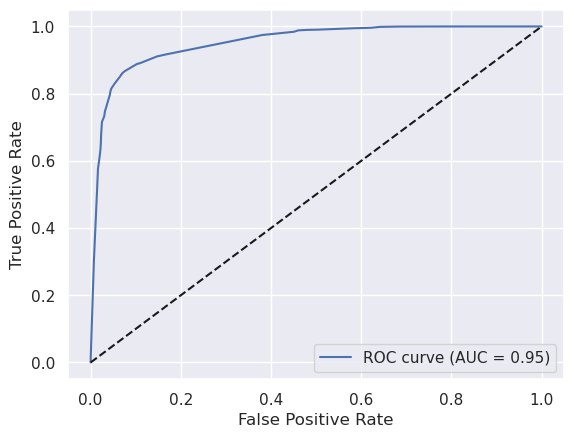

In [25]:
pf.plot_roc_curve(y_val,preds_proba_tree[:,1])

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='False Positive Rate', ylabel='True Positive Rate'>)

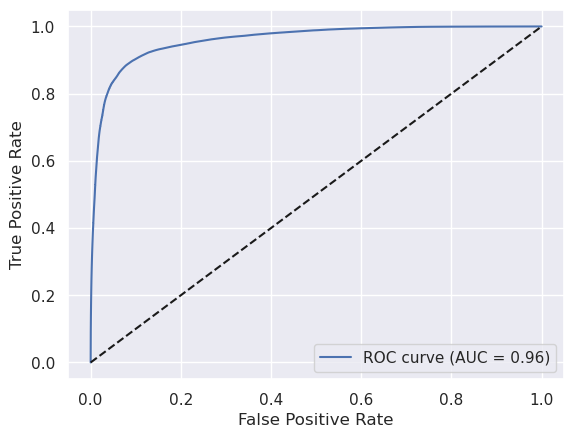

In [26]:
pf.plot_roc_curve(y_val,preds_proba_lgbm[:,1])

In [27]:
best_pipeline=models.models['lgbm_yn'].pipeline

 98%|===================| 9752/10000 [00:20<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


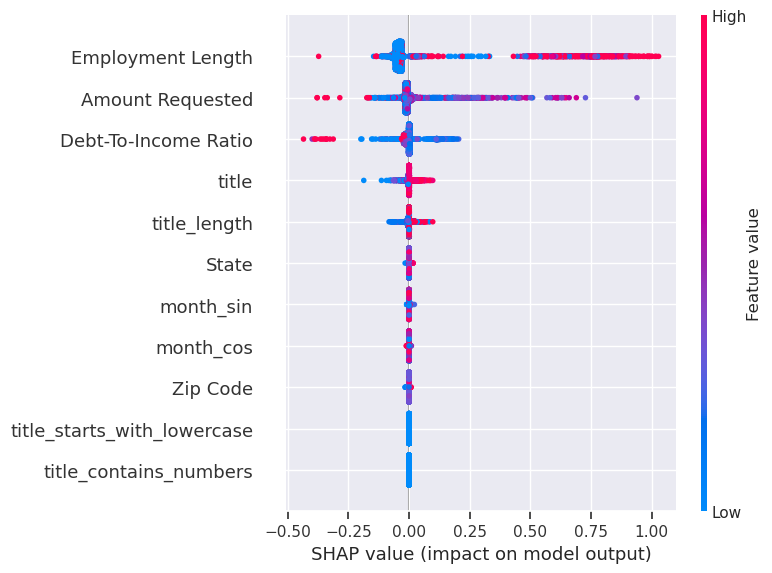

In [28]:
names = best_pipeline["preprocess"].transform(X_mini_val.sample(1000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    best_pipeline["model"],
    data=best_pipeline["preprocess"]
    .transform((X_mini_val.sample(10000, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    best_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    best_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=20,
)

In [29]:
best_pipeline.fit(X_train.vstack(X_val), pl.concat([y_train,y_val]))

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=OrderedDict([('title_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fa875170a30>),
                                                                             ('zip_code_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fa93cb978e0>),
                                                                             ('state_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step ob...
                 LGBMClassifier(bagging_freq=0, boosting_type='rf',
                                colsample_bytree=0.5271056292188826,
                                force_col_wise=True,
                                learning_rate=0.0035177130677962617,
                                max_bin=184, n_estimators=81, num_leaves=102,
                                num_threads=1,
                                random_state=RandomState(MT19937) at 0x7FAB23C32B40,
                                reg_alpha=2.8552865967655805,
                                reg_lambda=0.00325459871999461,
                                subsample=0.45336580978495056, verbose=-1))])

In [30]:
data_test=pl.read_parquet('data/data_full_test.parquet')

In [31]:
data_test=dmf.clean_accepted_rejected(data_test)
data_test=feats.date_features_accepted_rejected(data_test,"Application Date")
data_test=feats.title_text_features(data_test)

X_test = data_test.drop(columns=["Policy Code"])
y_test = data_test["Policy Code"]

In [32]:
final_preds = best_pipeline.predict(X_test)
print(classification_report(data_test["Policy Code"], final_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98   9496782
           1       0.61      0.74      0.67    495242

    accuracy                           0.96   9992024
   macro avg       0.80      0.86      0.83   9992024
weighted avg       0.97      0.96      0.97   9992024



In [33]:
best_pipeline.fit(X_train.vstack(X_val).vstack(X_test), pl.concat([y_train,y_val,y_test]))
joblib.dump(best_pipeline,"trained_models/final_model_accepted_rejected.joblib")

['trained_models/final_model_accepted_rejected.joblib']